# Visual Inspection of an Object

In the [Aperture photometry tutorial](Aperture-Photometry-Tutorial.html) we learned how to make our own apertures and ensure that they covered the right object. Now we need to understand how to interpret and examine our light curves.  

In this tutorial we learn the following,
- How to interactively inspect our object of interest using the *Lightcurve* interact tool.
- What features in a light curve may be caused by certain anomalies or by contamination from another star.
- How to create and store aperture arrays via an interactive tool.



## Imports
This tutorial requires:
- [**Lightkurve**](https://docs.lightkurve.org) 
- [**Matplotlib**](https://matplotlib.org/) 
- [**Numpy**](https://numpy.org)
- [**astrowidgets**](https://pypi.org/project/astrowidgets/)
- [**opencv-python**](https://pypi.org/project/opencv-python/)

In [1]:
%matplotlib inline 
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

## Defining terms

- Target Pixel File (TPF): A file containing the original CCD pixel observations from which light curves are extracted. 

- LightCurve Object: Obtained from a TPF and contains light curve information derived using simple aperture photometry.

- LightCurveFile Object: Obtained from MAST and contains both SAP flux and PSDCSAP flux.
    
- SAP: Simple aperture photometry

- PDCSAP: Pre-search Data Conditioning SAP

- Cadence: The rate at which TESS photometric observations are stored. 

- Sector: One of TESS's 27 (to date) observing periods, approximately ~27 days in duration.

## Downloading data

We will be using [Gaia object DR25290850609994130560](https://arxiv.org/pdf/2005.12281.pdf) in this tutorial. This object was observed in TESS FFI data. We'll use the [`search_tesscut`](https://docs.lightkurve.org/api/lightkurve.search.search_tesscut.html) function to download a cut out of the target in all sectors observed. You can determine which sectors the target was observed in using the [MAST TESS portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html).

Lets grab our data for Gaia object DR25290850609994130560.

In [2]:
search_result = lk.search_tesscut('Gaia DR25290850609994130560')
print(search_result)

SearchResult containing 5 data products.

 #   observation   author         target_name         productFilename distance
--- -------------- ------ --------------------------- --------------- --------
  0  TESS Sector 4   MAST Gaia DR25290850609994130560         TESSCut      0.0
  1  TESS Sector 7   MAST Gaia DR25290850609994130560         TESSCut      0.0
  2  TESS Sector 8   MAST Gaia DR25290850609994130560         TESSCut      0.0
  3  TESS Sector 9   MAST Gaia DR25290850609994130560         TESSCut      0.0
  4 TESS Sector 10   MAST Gaia DR25290850609994130560         TESSCut      0.0


We see  that this object has been observed in 5 sectors. Lets download the data for sector 8, and cut out a region of 10 x 10 pixels.

In [3]:
search_result = lk.search_tesscut('Gaia DR25290850609994130560', sector=8)
tpfs = search_result.download(cutout_size=10)
tpfs

TessTargetPixelFile(TICID: Gaia DR25290850609994130560)

## Plot and inspect the data 
FFI cut outs do not have a SPOC defined *optimal* apertures, we must therefore define our own as in the previous [Aperture photometry tutorial](Aperture-Photometry-Tutorial.html). We can define our mask initially using a threshold cut as shown below.

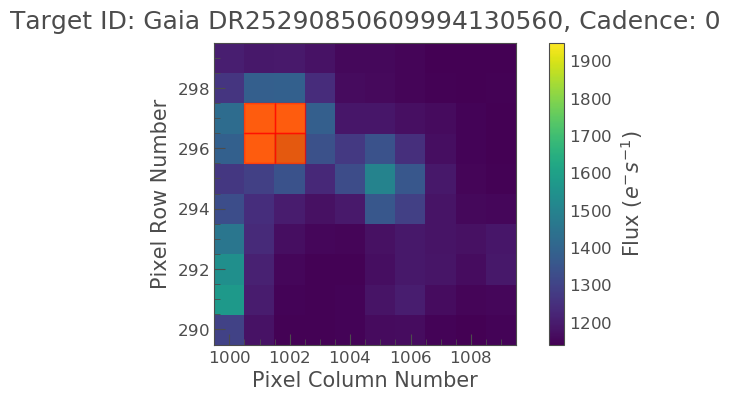

In [4]:
target_mask = tpfs.create_threshold_mask(threshold=10, reference_pixel='center')
tpfs.plot(aperture_mask=target_mask, mask_color='r');

Oh no! It looks like the bright object next to our object of interest was covered. We have to correct this by specifying a mask array.

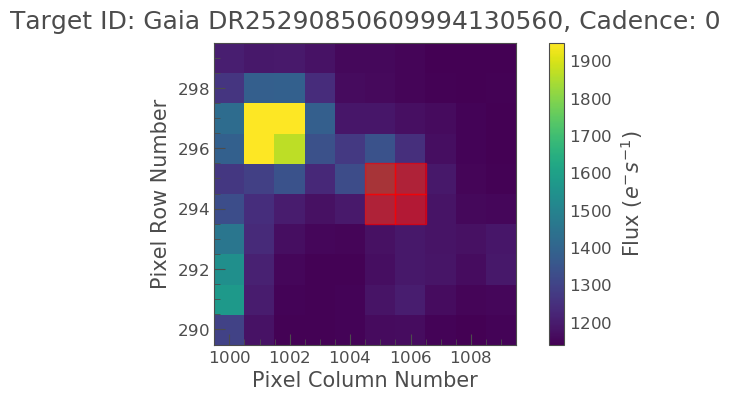

In [5]:
aper_new = np.zeros(tpfs.shape[1:], dtype=bool)
aper_new[4:6, 5:7] = True
tpfs.plot(aperture_mask=aper_new, mask_color='red')

OK phew! Our object is now covered by the aperture. Lets take a look at the light curve data using this aperture.

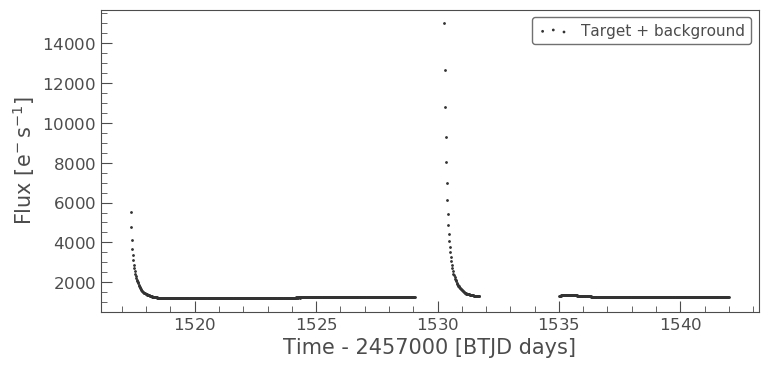

In [6]:
target_lc = tpfs.to_lightcurve(aperture_mask=aper_new)
target_lc.scatter(label='Target + background')

Above we see that the object looks to have some sort of variability. There also appears to be some sort of data gap. What is this caused by? Lets check the [TESS Data Release Notes](https://archive.stsci.edu/missions/tess/doc/tess_drn/tess_sector_08_drn10_v02.pdf) for sector 8. If we look at this we see that there was an instrument anomaly starting on 1531 and ending 1535.  This explains some of issues we are seeing.

What about the two bright peaks though, this is unlikely from our object of interest. It might be useful to visually inspect these cadences to better understand what is happening. 

One tool provided by *Lightkurve* to investigate such an event is [`interact`](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.TessTargetPixelFile.html?highlight=interact#lightkurve.targetpixelfile.TessTargetPixelFile.interact). Lets use this tool and see what happens.

In [7]:
tpfs.interact()

No pixels in `aperture_mask`, finding optimum aperture using `tpf.create_threshold_mask`.


Above you will see a light curve plot to the left, and a TPF postage stamp to the right. 

In the light curve plot you can move the large bottom left slider to change the location of the vertical red bar, which indicates which cadence is being shown in the TPF postage stamp image. 

The slider beneath the TPF postage stamp image on the right controls the screen stretch, which defaults to logarithmic scaling initialized to 1% and 95% lower and upper limits respectively.

You can move your cursor over individual data points to show hover-over tool-tips indicating additional information about that data. Currently the tool tips list the cadence, time, flux, and quality flags. 

The tools on the right hand side of the plots enable zooming, and pixel selection.

The gif below illustrates these features and more,

In [8]:
from IPython.display import Image
Image(url='https://docs.lightkurve.org/_images/20180925_interact_EB_contam.gif')

Lets move the cadence slider to a the peak flux date, so somewhere around 1435 days. If you do this you see that the entire TPF becomes completely yellow indicating saturation! What could be causing this?

### Scattered light

Given the repetative nature of the light curve and the saturation observed upon inspection it is likely that this issue is caused by scattered light. Each camera has a lens hood to reduce the scattered light from the Earth and the Moon. Due to TESS's wide field of view and the physical restrictions of the Sun shade the lens hood is not 100% efficient. The effect of the scattered light on the CCD's can be seen in the video below, typically the patchy brightness is 2-6 times that of the nominal sky background and covers approximately 10-15% of the FoV. When the Earth is below the level of the sun shade there is no scattered light. When the Earth or Moon is directly in the FoV of a camera the data is no longer viable.

In [9]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('https://www.youtube.com/watch?v=p_B85Lot8iU')

We have demonstrated one use for the interact tool, but there are several different modes that you can access,

Interaction modes:

- Clicking on a single pixel shows the time-series light curve of that pixel alone.

- Shift-clicking on multiple pixels shows the light curve using that pixel mask.

- Shift-clicking on an already-selected pixel will de-select that pixel.

- Clicking and dragging a box will make a rectangular aperture mask– individual pixels can be deselected from this mask by shift-clicking (box de-selecting does not work).

- The screen stretch high and low limits can be changed independently by clicking and dragging each end, or simultaneously by clicking and dragging in the middle.

- The cadence slider updates the postage stamp image at the position of the vertical red bar in the light curve.

- Clicking on a position in the light curve automatically seeks to that Cadence Number.

- The left and right arrows can be clicked to increment the cadence number by one.


One of the most useful applications of the interact tool is the ability to select pixels that make up your aperture. You can do this via shift-clicking on multiple pixels until you have created your pixel mask. Once satisfied you can then save your aperture and subsequent light curve as fits file by clicking the green `save lightcurve` button.

A limitation to *Lightkurve* is that each TPF is inspected one at a time, this can be difficult when you want to create multiple custom apertures and obtain a light curve over many sectors for a given object. A work around to this is described below. 

## An alternative aperture selection tool

Below we illustrate how one can load in a TPF, select pixels for an aperture mask, and save these pixels in an array to be applied at a later point. This avoids having to create a fits file.

In [10]:
def image_inspect(tess_cut, epoch):
    import astrowidgets
    from astrowidgets import ImageWidget
    
    iw = ImageWidget()
    iw.load_array(np.array(tess_cut.flux[epoch]))
    
    gv = iw._viewer
    # set a color map on the viewer 
    gv.set_color_map('jet')
    # Set color distribution algorithm
    # choices: linear, log, power, sqrt, squared, asinh, sinh, histeq, 
    gv.set_color_algorithm('linear')
    gv.auto_levels()
    
    canvas = gv.add_canvas()
    canvas.delete_all_objects()
    canvas.set_drawtype('point', color='black')
    
    return iw, canvas
    
def inter_mask(canvas):

    mask_arrayx=[]
    mask_arrayy=[]
    
    aper_out = np.zeros([10,10], dtype=bool)

    for a in range(len(canvas.objects)):
        p = canvas.objects[a]
        print(np.round(p.x,0),np.round(p.y,0))
        mask_arrayx.append(int(np.round(p.x,0)))
        mask_arrayy.append(int(np.round(p.y,0)))
        
        aper_out = np.zeros([10,10], dtype=bool)
        aper_out[mask_arrayy,mask_arrayx] = True
        
    return aper_out
    

The following lines of code will bring up a *canvas* displaying the TPF. The user can place their mouse on the canvas and select pixels via clicking on them, this will bring up a black cross. The pixels selected will then be stored in an array that can be applied as an aperture mask.

In [11]:
iw, canvas = image_inspect(tpfs, 1)
iw

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [12]:
aper2 = inter_mask(canvas)

5.0 6.0
5.0 5.0
4.0 5.0
6.0 5.0
5.0 4.0
6.0 4.0
4.0 6.0
6.0 6.0
4.0 4.0


Great we now have these pixels stored in an array called aper2. Lets plot the aperture on top of the TPF as we did in the past and make sure it falls where we expect.

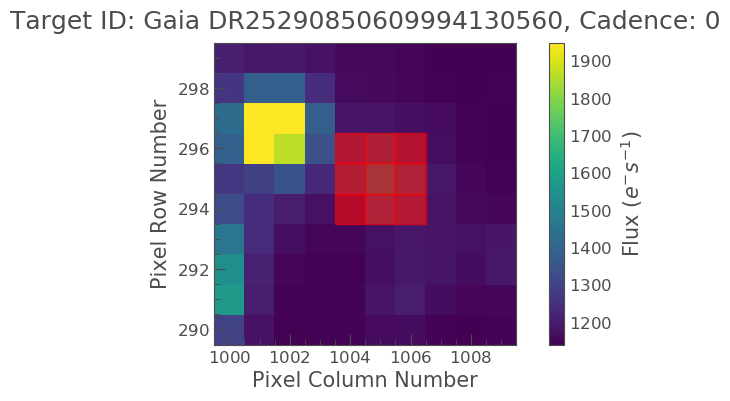

In [13]:
tpfs.plot(aperture_mask=aper2, mask_color='r');

Our interactive aperture is exactly where we expect it to be. Lets now look at the flux in that aperture and plot up its light curve.

In [14]:
target_lc= tpfs.to_lightcurve(aperture_mask=aper2)
print(target_lc)

       time               flux            flux_err      ... cadenceno quality
                      electron / s      electron / s    ...                  
------------------ ----------------- ------------------ ... --------- -------
1517.3666381835938   11895.255859375  3.193638801574707 ...         0    2048
1517.3875122070312   10188.751953125  2.984729290008545 ...         1    2048
1517.4083251953125   8872.3232421875 2.8149912357330322 ...         2       0
1517.4291381835938  7873.26806640625 2.6775903701782227 ...         3       0
1517.4500122070312   7127.3603515625  2.568751335144043 ...         4       0
1517.4708251953125  6547.95947265625  2.483670473098755 ...         5       0
1517.4916381835938  6070.17919921875 2.4083080291748047 ...         6       0
1517.5125122070312  5667.85791015625  2.345278024673462 ...         7       0
1517.5333251953125            5325.0 2.2904396057128906 ...         8       0
1517.5541381835938   5023.4169921875  2.240952730178833 ...     

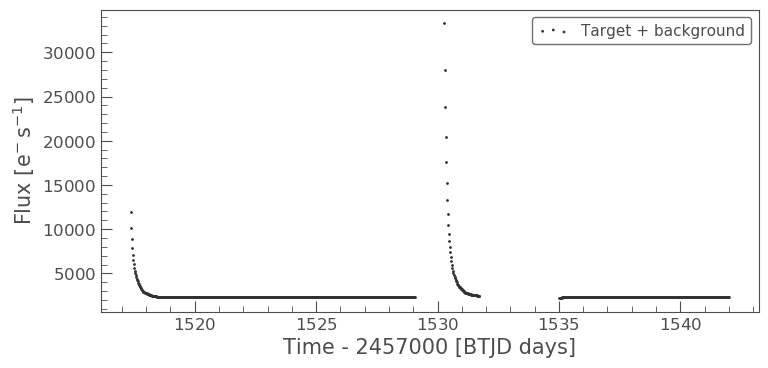

In [15]:
target_lc.scatter(label='Target + background')

We have now demonstrated how to interactively inspect TPF files and select apertures in multiple ways. 
We have learned about scattered light and how it can dominate a light curve.